### Problem
The goal of this project is to develop a machine learning model capable of identifying fraudulent credit card transactions. Fraud detection is a critical task in the financial industry, as it helps prevent significant financial losses and protects customers from unauthorized activities. The model aims to achieve high recall for detecting fraud cases while maintaining acceptable precision to minimize false positives.



**About the Dataset**
The dataset used in this project is sourced from Kaggle: https://www.kaggle.com/datasets/kartik2112/fraud-detection?utm_source=chatgpt.com
This is a simulated credit card transaction dataset containing legitimate and fraud transactions from the duration 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants.

In [242]:
import pandas as pd
import numpy as np

from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from xgboost import XGBClassifier


data0 = pd.read_csv('fraudTest.csv')

### Data Preprocessing
**Missing Value Handling**: Ensure all columns have no missing values.  
**Datetime Feature Extraction**: Extract date, time, hour, etc., from `trans_date_trans_time`.  
**Geographic Features**: Calculate the distance between user and merchant locations.  
**Categorical Encoding**: Encode `merchant`, `category`, `state`, `job`, etc., using One-Hot or Label Encoding.  
**Age Calculation**: Compute user age based on `dob`.  
**Feature Scaling**: Normalize numerical columns such as `amt`, `city_pop`.  
**Drop Irelavant Columns**:removing features that do not contribute meaningfully to the predictive task. Irrelevant features, such as personal identifiers (e.g., names, IDs), and redundant or duplicated columns are excluded to reduce noise, avoid overfitting, and streamline the dataset for modeling.

In [148]:
data.dropna(inplace=True)  # Drop rows with missing values
print(f"Data shape after dropping missing values: {data0.shape}")
print("Checking for missing values:")
missing_values = data.isnull().sum()
print(missing_values)

Data shape after dropping missing values: (555719, 23)
Checking for missing values:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
hour                     0
day_of_week              0
month                    0
year                     0
distance                 0
category_encoded         0
gender_encoded           0
age                      0
dtype: int64


In [273]:
# DateTime Feature Extraction
data = data0
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['hour'] = data['trans_date_trans_time'].dt.hour
data['day_of_week'] = data['trans_date_trans_time'].dt.dayofweek
data['month'] = data['trans_date_trans_time'].dt.month
data['year'] = data['trans_date_trans_time'].dt.year

# Geographic Features (Distance Calculation)
user_locations = list(zip(data['lat'], data['long']))
merchant_locations = list(zip(data['merch_lat'], data['merch_long']))
data['distance'] = [geodesic(u, m).kilometers for u, m in zip(user_locations, merchant_locations)]

# Categorical Feature Encoding
label_encoder = LabelEncoder()
data['category_encoded'] = label_encoder.fit_transform(data['category'])
data['gender_encoded'] = label_encoder.fit_transform(data['gender'])

# Age Calculation
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = (pd.to_datetime('today') - data['dob']).dt.days // 365 -4

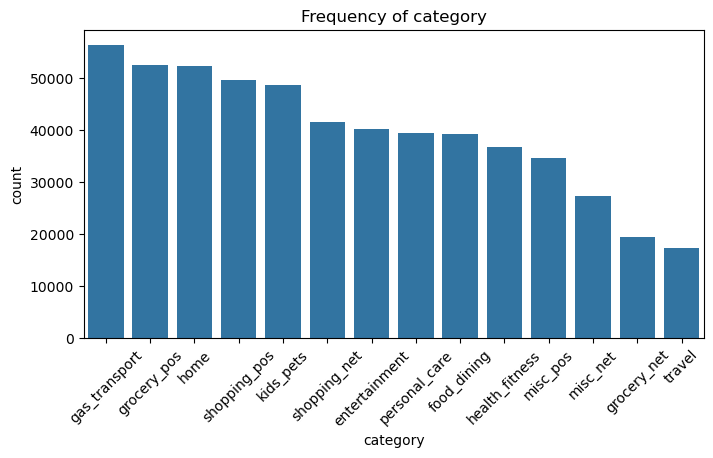

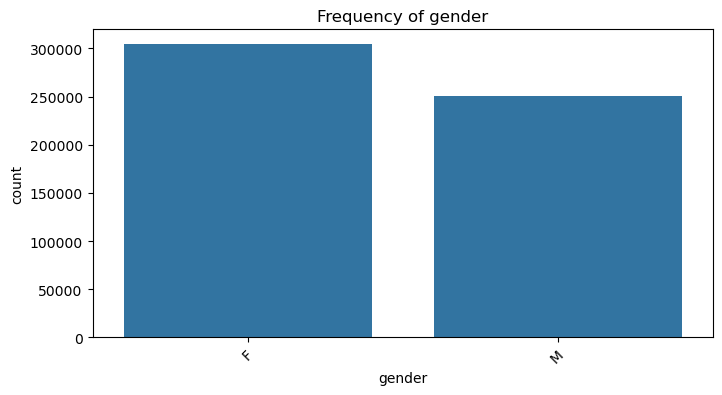

In [176]:
# Categorical Features: Frequency Plot
categorical_cols = ['category', 'gender',]
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=col, order=data[col].value_counts().index)
    plt.title(f'Frequency of {col}')
    plt.xticks(rotation=45)
    plt.show()

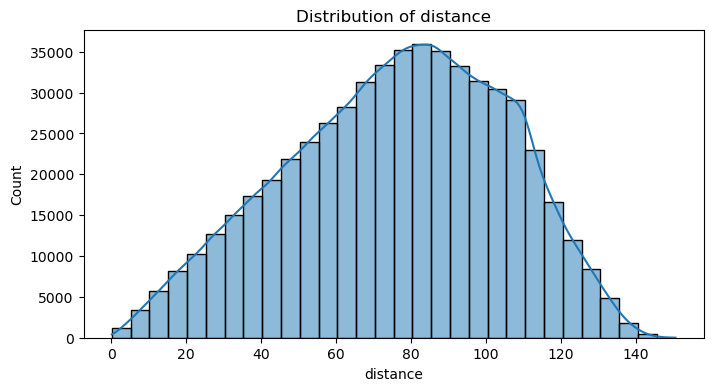

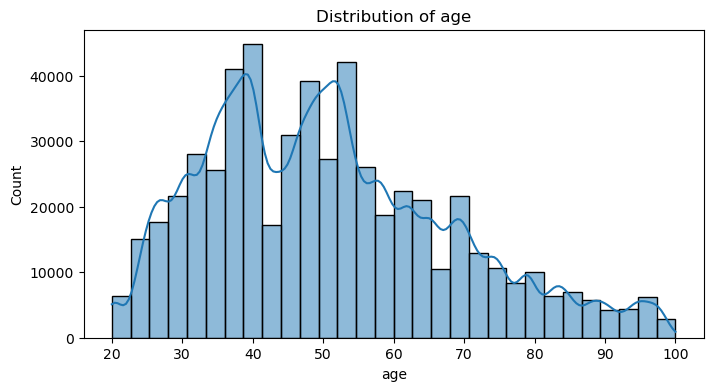

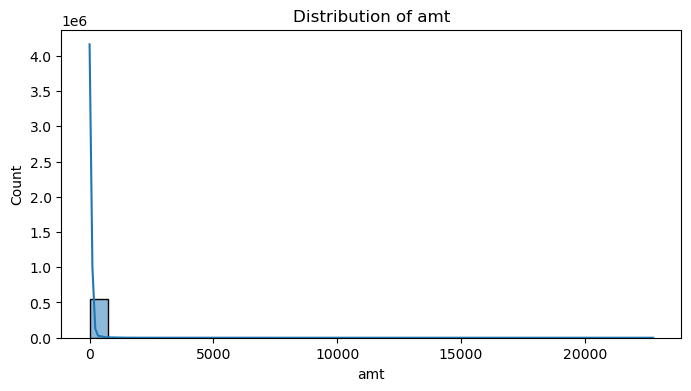

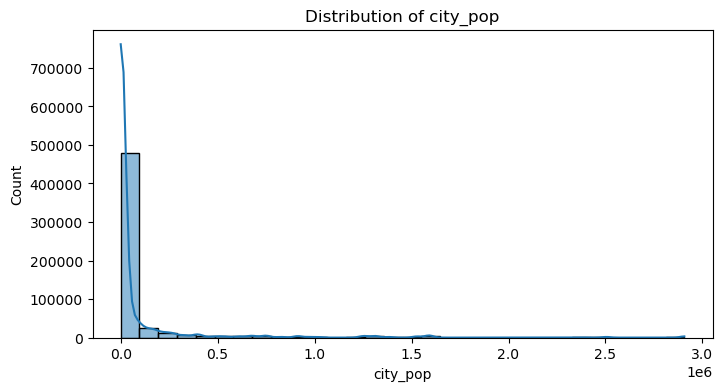

In [37]:
# Numerical Features: Distribution Plots
numerical_cols = ['distance', 'age','amt', 'city_pop']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

In [113]:
fraud_count_before = data['is_fraud'].sum()
for i in range(1, 6):  # Loop from 1 to 7
    threshold = 2000 - 200 * i
    data1 = data0[data0['amt'] < threshold]
    fraud_count_after = data1['is_fraud'].sum()
    print(f"Threshold: {threshold}, Fraud Count After: {fraud_count_after}, "
          f"Fraud Count Before: {fraud_count_before}, Percentage Retained: {fraud_count_after / fraud_count_before * 100:.2f}%\n")

Threshold: 1800, Fraud Count After: 2145, Fraud Count Before: 2145, Percentage Retained: 100.00%

Threshold: 1600, Fraud Count After: 2145, Fraud Count Before: 2145, Percentage Retained: 100.00%

Threshold: 1400, Fraud Count After: 2145, Fraud Count Before: 2145, Percentage Retained: 100.00%

Threshold: 1200, Fraud Count After: 2138, Fraud Count Before: 2145, Percentage Retained: 99.67%

Threshold: 1000, Fraud Count After: 1869, Fraud Count Before: 2145, Percentage Retained: 87.13%



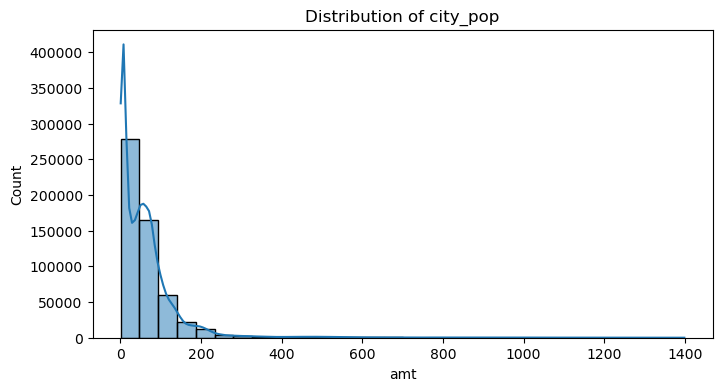

In [151]:
data = data[data['amt']<1400]
plt.figure(figsize=(8, 4))
sns.histplot(data['amt'], kde=True, bins=30)
plt.title(f'Distribution of {col}')
plt.show()

In [220]:
# Feature Scaling
data = data.copy()
scaler = StandardScaler()
data[['amt', 'city_pop', 'distance']] = scaler.fit_transform(
    data[['amt', 'city_pop', 'distance']]
)

# Feature dropping
data = data.drop(columns=['Unnamed: 0', 'category','state','merchant','cc_num', 'trans_num', 'first', 'last', 'unix_time','gender','street','merch_lat','merch_long', 'city', 'zip', 'dob', 'job','trans_date_trans_time','lat','long'],errors='ignore')

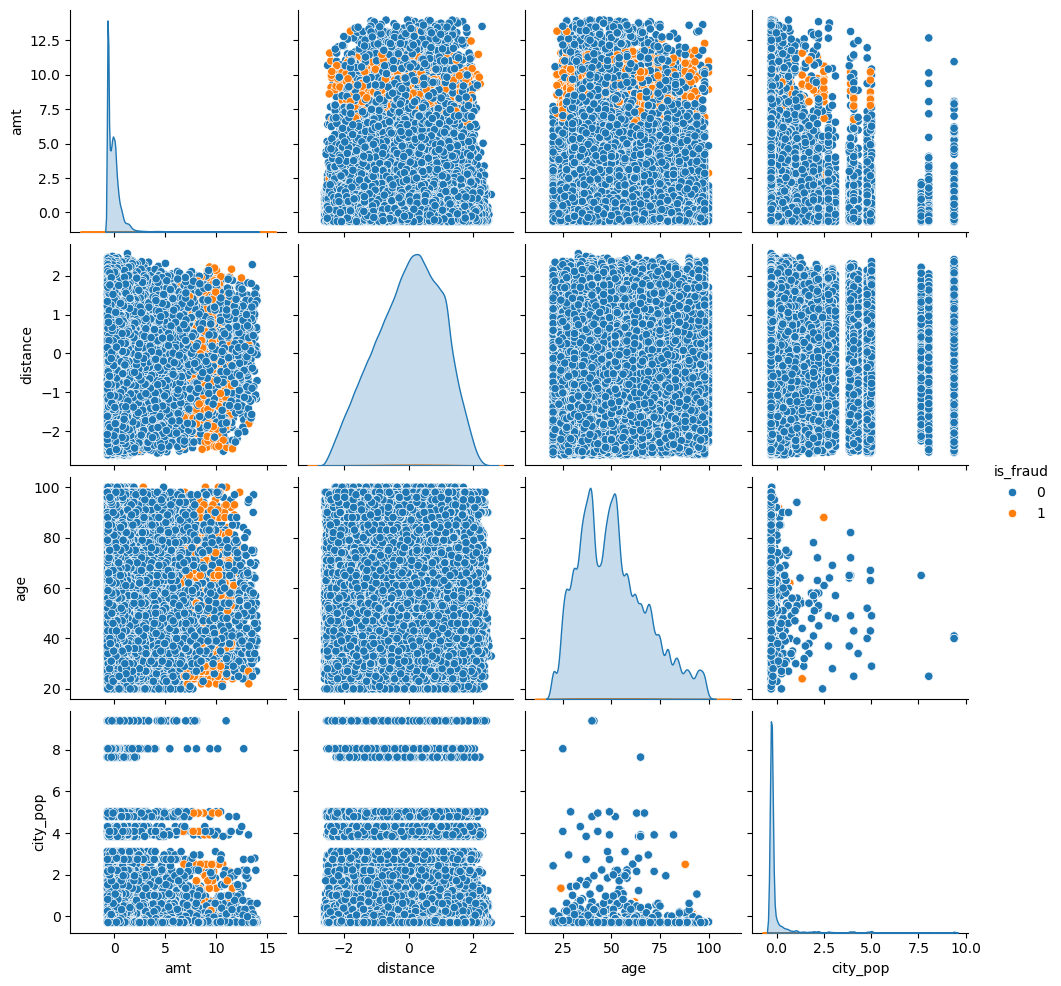

In [127]:
selected_features = ['amt', 'distance', 'age', 'city_pop', 'is_fraud']
sns.pairplot(data[selected_features], hue='is_fraud', diag_kind='kde')
plt.show()

### Split Dataset

In [222]:
# Define features and target
X = data.drop(columns=['is_fraud'])  # Features
y = data['is_fraud']  # Target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 444011
Test set size: 111003


### the Random Forest model

In [259]:
# Train the Random Forest model
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC
RandomForest = classification_report(y_test, y_pred)
print("Classification Report:")
print(RandomForest)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110574
           1       0.97      0.68      0.80       429

    accuracy                           1.00    111003
   macro avg       0.98      0.84      0.90    111003
weighted avg       1.00      1.00      1.00    111003



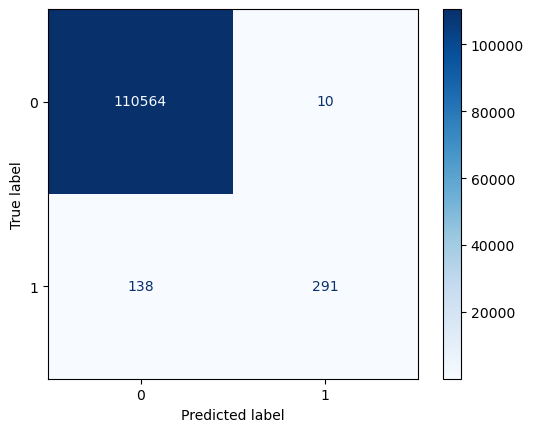

In [234]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')

ROC-AUC Score: 0.98


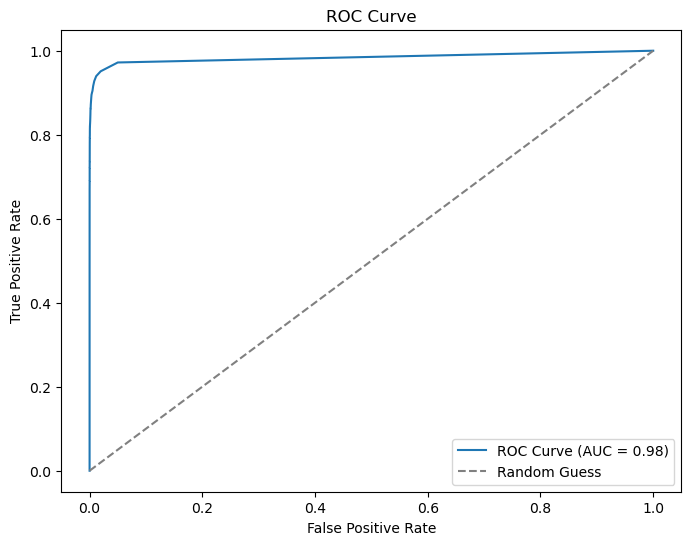

In [236]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


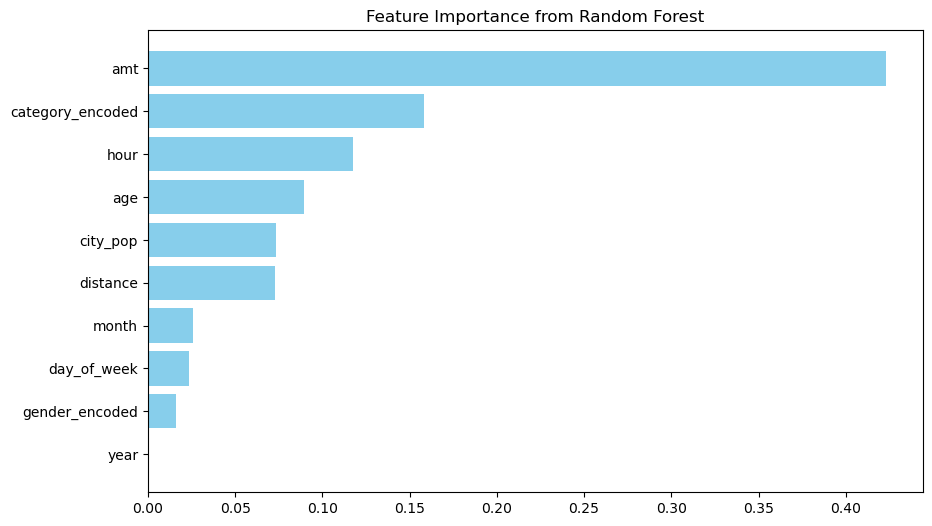

            Feature  Importance
0               amt    0.423104
7  category_encoded    0.158367
2              hour    0.117267
9               age    0.089517
1          city_pop    0.073637
6          distance    0.072736
4             month    0.025849
3       day_of_week    0.023556
8    gender_encoded    0.015967
5              year    0.000000


In [238]:
# Extract feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

print(importance_df)

### XGBoost Classifier

In [268]:
xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=100,              # Number of boosting rounds
    learning_rate=0.1,             # Step size shrinkage
    max_depth=6,                   # Maximum depth of a tree
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Handle class imbalance
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC
XGBoost = classification_report(y_test, y_pred)

print("Classification Report:")
print(XGBoost)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    110574
           1       0.29      0.96      0.44       429

    accuracy                           0.99    111003
   macro avg       0.64      0.97      0.72    111003
weighted avg       1.00      0.99      0.99    111003



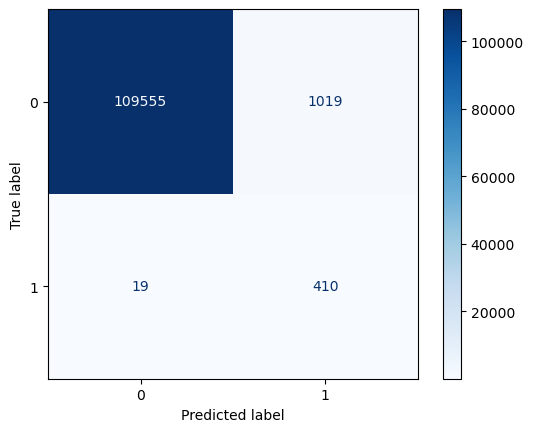

In [270]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')

ROC-AUC Score: 1.00


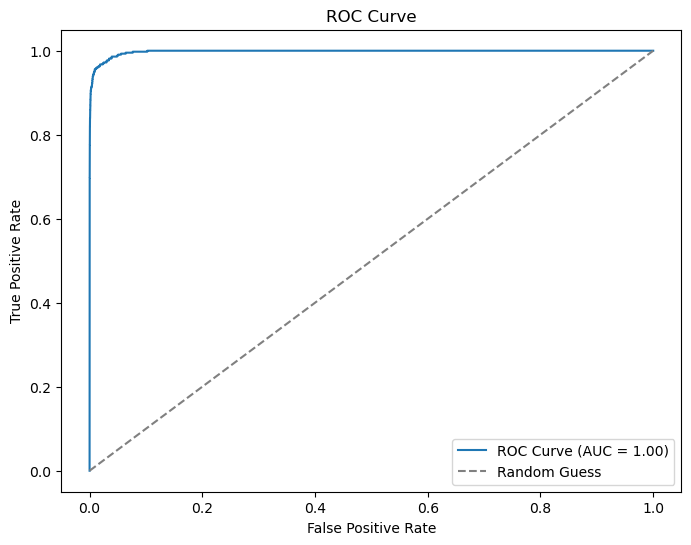

In [250]:
# Calculate and print ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


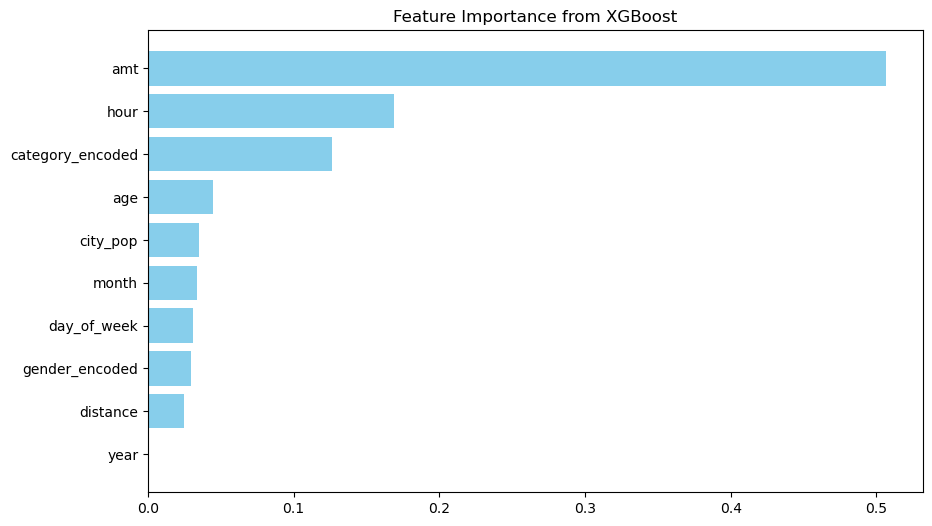

            Feature  Importance
0               amt    0.506658
2              hour    0.168702
7  category_encoded    0.126617
9               age    0.044846
1          city_pop    0.035225
4             month    0.033420
3       day_of_week    0.030733
8    gender_encoded    0.029254
6          distance    0.024545
5              year    0.000000


In [252]:
# Extract feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()

print(importance_df)

### Compare of both Method

In [263]:
print("Classification Report for random forest:")
print(RandomForest)
print("Classification Report for XGBoost:")
print(XGBoost)

Classification Report for random forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110574
           1       0.97      0.68      0.80       429

    accuracy                           1.00    111003
   macro avg       0.98      0.84      0.90    111003
weighted avg       1.00      1.00      1.00    111003

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    110574
           1       0.29      0.96      0.44       429

    accuracy                           0.99    111003
   macro avg       0.64      0.97      0.72    111003
weighted avg       1.00      0.99      0.99    111003



### Conclusion
- **Key insights** from feature importance analysis revealed that:
Transaction Amount (amt) is the most critical feature for detecting fraud.
Transaction Category (category_encoded) and Transaction Hour (hour) also play significant roles.

- Two machine learning models, **Random Forest** and **XGBoost**, were trained and evaluated:


        Random Forest achieved higher precision (97%) but lower recall (68%), resulting in missed fraud cases.
        XGBoost achieved higher recall (96%), detecting almost all fraud cases, but at the cost of lower precision (29%).


- The trade-off between recall and precision is significant in fraud detection. While Random Forest reduces false positives, XGBoost minimizes false negatives, making it more suitable for scenarios where catching fraudulent transactions is a priority.

- Recommendation -- To improve overall performance, a combined approach can be implemented:

        1.Use XGBoost to detect potential fraud cases (high recall).
        2.Validate flagged cases using Random Forest (high precision).


Github Link : https://github.com/LukooX/Data-Science-Learning/blob/main/Credit_card_fraud_detection.ipynb